In [4]:
from __future__ import print_function
import numpy as np
import numpy.linalg as LA
from scipy import optimize
from maxvolpy.maxvol import rect_maxvol, maxvol
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import gen_mat as gen
import grad_log_det as log_det # this is a module with analytical calculation of gradient and objective 
from test_bench import test_points_gen
#from autograd import grad
from numba import jit, njit, prange
from test_bench import *
import os
import itertools
import fnmatch
import re
%matplotlib inline

In [7]:
all_files = os.listdir("/Users/vitaly/Downloads/maxvol-approximation/res_IPOPT/")

In [8]:
cheb = []
trigpoly = []
herm = []
for i in all_files:
    if fnmatch.fnmatch(i, '*_poly=cheb*'):
        cheb.append(i)
    if fnmatch.fnmatch(i, '*_poly=herm_nn*'):
        herm.append(i)
    if fnmatch.fnmatch(i, '*_poly=trigpoly*'):
        trigpoly.append(i)

In [9]:
srch = re.search('cols=(\d+)_points=(\d+)_',cheb[0])

In [10]:
srch.group(1)

'10'

In [11]:
{int(re.search('cols=(\d+)_points=(\d+)_', fn).group(1)) for fn in cheb}

{5, 10, 15, 20, 21, 36, 37, 40, 45, 50}

In [12]:
tol = 1e-12
def loss_func(points, num_col, poly=gen.cheb, ToGenDiff=False):
    if (points.ndim == 1 or points.shape[1] == 1):
        points = points.reshape(-1, dim, order='F')
    A = gen.GenMat(num_col, points, poly=poly, ToGenDiff=ToGenDiff)
    S = LA.svd(A, compute_uv = False)
    S[ S < tol ] = tol
    ld = 2.0*np.sum(np.log(S))
    return -ld

In [ ]:
dim = 2
np.random.seed(42)
myfunc = lambda x, y : f_sincos(5*x, 5*y)
test_pnts = test_points_gen(int(1e5), dim)

ff = MakeValsAndNorms([myfunc], test_pnts)

SCIPY_C_logdet = np.NaN*np.ones((79+1,50+1))

SCIPY_C_lebesgue = np.NaN*np.ones((79+1,50+1))
SCIPY_C_error = np.NaN*np.ones((79+1,50+1))
SCIPY_C_clusters = np.NaN*np.ones((79+1,50+1))
for i in cheb:
    n_col = int(re.search('cols=(\d+)_points=(\d+)_', i).group(1))
    n_pnts = int(re.search('cols=(\d+)_points=(\d+)_', i).group(2))
    pnts = np.load("/Users/vitaly/Downloads/maxvol-approximation/GD/"+i)['pnts']
    buf = LebesgueConst(pnts, n_col, poly=gen.cheb, test_pnts=test_pnts, pow_p=1, funcs=ff)
    
    SCIPY_C_logdet[n_pnts,n_col] = loss_func(pnts, num_col = n_col)
    
    SCIPY_C_lebesgue[n_pnts,n_col] = buf[0]
    SCIPY_C_error[n_pnts,n_col] = buf[1]
    SCIPY_C_clusters[n_pnts,n_col] = NumOfClusters(pnts, full=False)

KeyboardInterrupt: 

In [ ]:
dim = 2
np.random.seed(42)
test_pnts = test_points_gen(int(1e5), dim)

ff = MakeValsAndNorms([myfunc], test_pnts)

IPOPT_C_logdet = np.NaN*np.ones((79+1,50+1))

IPOPT_C_lebesgue = np.NaN*np.ones((79+1,50+1))
IPOPT_C_error = np.NaN*np.ones((79+1,50+1))
IPOPT_C_clusters = np.NaN*np.ones((79+1,50+1))
for i in cheb:
    n_col = int(re.search('cols=(\d+)_points=(\d+)_', i).group(1))
    n_pnts = int(re.search('cols=(\d+)_points=(\d+)_', i).group(2))
    pnts = np.load("/Users/vitaly/Downloads/maxvol-approximation/res_IPOPT/"+i)['pnts']
    buf = LebesgueConst(pnts, n_col, poly=gen.cheb, test_pnts=test_pnts, pow_p=1, funcs=ff)

    IPOPT_C_logdet[n_pnts,n_col] = loss_func(pnts, num_col = n_col)
    
    IPOPT_C_lebesgue[n_pnts,n_col] = buf[0]
    IPOPT_C_error[n_pnts,n_col] = buf[1]
    IPOPT_C_clusters[n_pnts,n_col] = NumOfClusters(pnts, full=False)

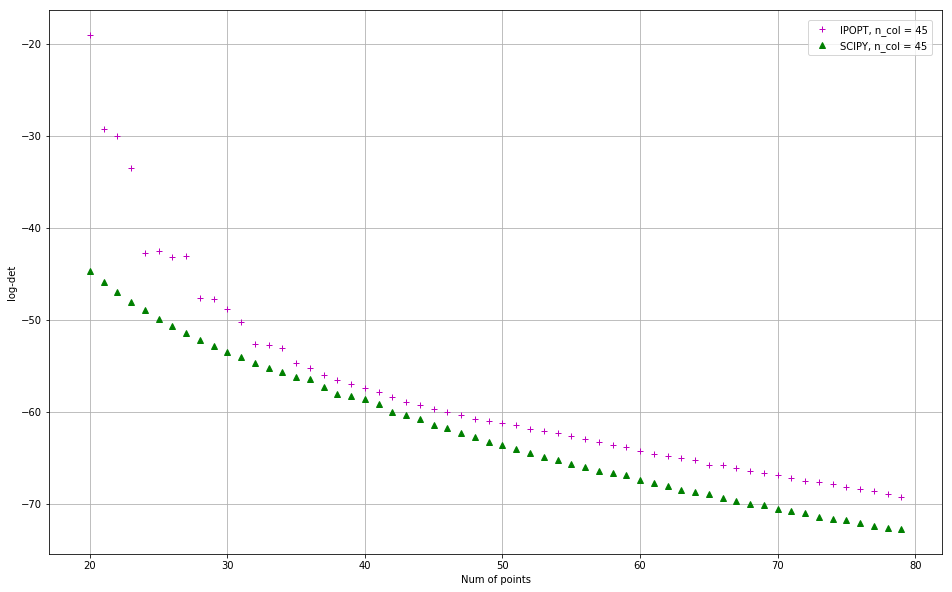

In [12]:
_, fig = plt.subplots(figsize=(16, 10))

plt.plot(range(80),IPOPT_C_logdet[:,20],'m+', label = 'IPOPT, n_col = 45')
plt.plot(range(80),SCIPY_C_logdet[:,20],'g^', label = 'SCIPY, n_col = 45')
plt.xlabel('Num of points')
plt.ylabel('log-det')
plt.legend(ncol=1, borderaxespad=1)
plt.grid()
plt.savefig('/Users/vitaly/Desktop/log-det.png', pdi = 600)
plt.show()

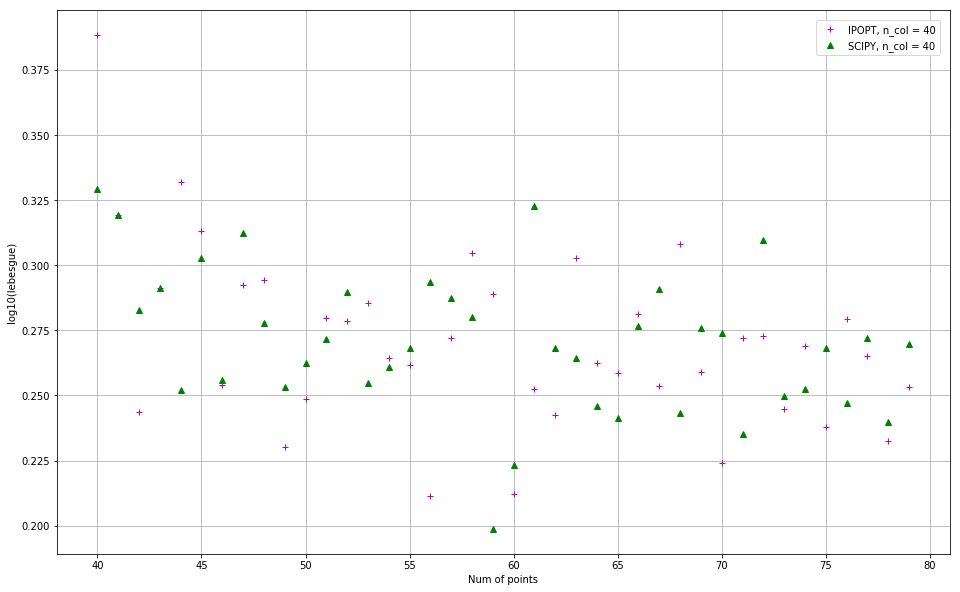

In [19]:
_, fig = plt.subplots(figsize=(16, 10))

num_col = 40
plt.plot(range(80),np.log10(IPOPT_C_error[:,num_col]),'m+', label = 'IPOPT, n_col = ' + str(num_col))
plt.plot(range(80),np.log10(SCIPY_C_error[:,num_col]),'g^', label = 'SCIPY, n_col = ' + str(num_col))
plt.xlabel('Num of points')
plt.ylabel('log10(lebesgue)')
plt.legend(ncol=1, borderaxespad=1)
plt.grid()
plt.savefig('/Users/vitaly/Desktop/lebesgue.png', pdi = 600)
plt.show()

In [ ]:
_, fig = plt.subplots(figsize=(16, 10))

fig = plt.imshow(IPOPT_C_error,cmap=cm.coolwarm, aspect='auto', origin='lower')
plt.xlabel('Columns')
plt.ylabel('Points')
title_obj = plt.title('Error')
plt.getp(title_obj, 'text') 
plt.colorbar(fig)
plt.grid()
plt.savefig('/Users/vitaly/Desktop/ipopt_error.png', pdi = 600)
plt.show()

In [ ]:
_, fig = plt.subplots(figsize=(16, 10))

fig = plt.imshow(IPOPT_C_lebesgue,cmap=cm.coolwarm, aspect='auto', origin='lower')
plt.xlabel('Columns')
plt.ylabel('Points')
title_obj = plt.title('Lebesgue')
plt.getp(title_obj, 'text') 
plt.colorbar(fig)
plt.grid()
plt.savefig('/Users/vitaly/Desktop/ipopt_leb.png', pdi = 600)
plt.show()

In [ ]:
_, fig = plt.subplots(figsize=(16, 10))

fig = plt.imshow(IPOPT_C_clusters,cmap=cm.coolwarm, aspect='auto', origin='lower')
plt.xlabel('Columns')
plt.ylabel('Points')
title_obj = plt.title('Clusters')
plt.getp(title_obj, 'text') 
plt.colorbar(fig)
plt.grid()
plt.savefig('/Users/vitaly/Desktop/ipopt_clust.png', pdi = 600)
plt.show()

In [ ]:
_, fig = plt.subplots(figsize=(16, 10))

plt.plot(IPOPT_C_clusters[:,10], np.log10(IPOPT_C_error[:,10]), 'm+')
plt.plot(IPOPT_C_clusters[:,21], np.log10(IPOPT_C_error[:,21]), '^')
plt.plot(IPOPT_C_clusters[:,36], np.log10(IPOPT_C_error[:,36]), 'bo')
plt.plot(IPOPT_C_clusters[:,40], np.log10(IPOPT_C_error[:,45]), 'rx')
plt.plot(IPOPT_C_clusters[:,50], np.log10(IPOPT_C_error[:,50]), 'g>')
plt.xlabel('Clusters')
plt.ylabel('Error')
plt.grid()
plt.savefig('/Users/vitaly/Desktop/ipopt_.png', pdi = 600)
plt.show()

In [ ]:
_, fig = plt.subplots(figsize=(16, 10))

plt.plot(C_lebesgue[:,10], C_error[:,10], 'm+')
plt.xlabel('Clusters')
plt.ylabel('Error')
plt.grid()
plt.show()

In [ ]:
leb = [C_lebesgue[x,x] for x in xrange(51)]

In [ ]:
_, fig = plt.subplots(figsize=(16, 10))
plt.plot(xrange(51), np.log(leb), 'go', xrange(51), np.log(leb_lhs), 'rx')
plt.grid()
plt.xlabel('Columns')
plt.ylabel('Lebesgue Constant')
title_obj = plt.title('L(N_col)')
plt.getp(title_obj, 'text')
plt.savefig('/Users/vitaly/Desktop/lebesgue_LHS_.png', pdi = 600)
plt.show()

In [1]:
leb_lhs = np.NaN*np.ones(51)
np.random.seed(42)
test_pnts = test_points_gen(int(1e5), dim)
for col in xrange(5,56):
    x_0 = test_points_gen(col, dim, distrib='LHS')
    leb_lhs[col-5] = LebesgueConst(x_0, col, poly=gen.cheb, test_pnts=test_pnts, pow_p=1)

NameError: name 'np' is not defined

In [ ]:
#_, fig = plt.subplots(figsize=(16, 10))
scipy_pnts = np.load("/Users/vitaly/Downloads/maxvol-approximation/GD/cols=20_points=22_poly=cheb.npz")['pnts']
ipopt_pnts = np.load("/Users/vitaly/Downloads/maxvol-approximation/res_IPOPT/cols=20_points=22_poly=cheb.npz")['pnts']                            

In [ ]:
_, fig = plt.subplots(figsize=(16, 10))
plt.plot(scipy_pnts[:,0], scipy_pnts[:,1], 'g^')
plt.plot(ipopt_pnts[:,0], ipopt_pnts[:,1], 'ro')
plt.grid()
plt.savefig('/Users/vitaly/Desktop/samples.png', pdi = 800)
plt.show()

In [ ]:
scipy_pnts

In [ ]:
NumOfClusters(scipy_pnts, full=True)

In [ ]:
scipy_pnts[19]